[View in Colaboratory](https://colab.research.google.com/github/DJCordhose/deep-learning-crash-course-notebooks/blob/master/U3-M7-nn-training.ipynb)

# Training a network with TensorFlow and the Keras API

## _Important_ if you let this run on Colab switch on the GPU option, because otherwise this part will take quite some time

In [0]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
%pylab inline
import matplotlib.pyplot as plt

Populating the interactive namespace from numpy and matplotlib


In [3]:
import pandas as pd
print(pd.__version__)

0.22.0


In [4]:
import tensorflow as tf
tf.logging.set_verbosity(tf.logging.ERROR)
print(tf.__version__)

1.10.1


In [5]:
# let's see what compute devices we have available, hopefully a GPU 
sess = tf.Session()
devices = sess.list_devices()
for d in devices:
    print(d.name)

/job:localhost/replica:0/task:0/device:CPU:0
/job:localhost/replica:0/task:0/device:GPU:0


In [6]:
# a small sane check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print(sess.run(hello))

b'Hello TF!'


In [7]:
from tensorflow import keras
print(keras.__version__)

2.1.6-tf


## Loading and preparing our data set for classification

In [8]:
!curl -O https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/data/insurance-customers-1500.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 26783  100 26783    0     0  26783      0  0:00:01 --:--:--  0:00:01 79711


In [0]:
df = pd.read_csv('./insurance-customers-1500.csv', sep=';')

In [10]:
df.head()

,speed,age,miles,group
0,98.0,44.0,25.0,1
1,118.0,54.0,24.0,1
2,111.0,26.0,34.0,0
3,97.0,25.0,10.0,2
4,114.0,38.0,22.0,1


In [11]:
df.describe()

,speed,age,miles,group
count,1500.000000,1500.000000,1500.000000,1500.000000
mean,122.492667,44.980667,30.434000,0.998667
std,17.604333,17.130400,15.250815,0.816768
min,68.000000,16.000000,1.000000,0.000000
25%,108.000000,32.000000,18.000000,0.000000
50%,120.000000,42.000000,29.000000,1.000000
75%,137.000000,55.000000,42.000000,2.000000
max,166.000000,100.000000,84.000000,2.000000


In [0]:
# same split of input and output columns as before

y = df['group']
df.drop('group', axis='columns', inplace=True)
X = df.as_matrix()

## Second important concept: To have an idea how well the training worked, we save some data to test our model on previously unseen data. 

* The real objective is to have a generalized model that works well on the test data.
* How well it performs on this test data as opposed to the training data tells us quite a bit as well.
* Typical splits are 60% for training and 40% for testing or 80/20
* It is important that we do not use the test data to tweak the hyper parameters of our learning strategy - in this case the test data would (indirectly) influence the training and can no longer tell how well we did
* evaluate the test date set only once at the end of your experiment

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization.jpg'>

In [0]:
from sklearn.model_selection import train_test_split

In [0]:
# using stratify we get a balanced number of samples per category (important!)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)

In [15]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((900, 3), (900,), (600, 3), (600,))

In [16]:
# we have (almost) the same number of samples per categoery in the training...
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([301, 300, 299]))

In [17]:
# ... and test dataset
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([200, 200, 200]))

In [0]:
# ignore this, it is just technical code to plot decision boundaries
# Adapted from:
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
# http://jponttuset.cat/xkcd-deep-learning/

from matplotlib.colors import ListedColormap

cmap_print = ListedColormap(['#AA8888', '#004000', '#FFFFDD'])
cmap_bold = ListedColormap(['#AA4444', '#006000', '#EEEE44'])
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#FFFFDD'])
font_size=25
title_font_size=40

def meshGrid(x_data, y_data, xlim=None, ylim=None):
    h = 1  # step size in the mesh
    if xlim == None:
        xlim = x_data.min(), x_data.max()
    if ylim == None:
        ylim = y_data.min(), y_data.max()
        
    x_min, x_max = xlim
    y_min, y_max = ylim
    xx, yy = np.meshgrid(np.arange(x_min - 1, x_max + 1, h),
                         np.arange(y_min - 1, y_max + 1, h))
    return xx, yy, xlim, ylim
    
def plot_prediction(clf, x_data, y_data, x_label, y_label, ground_truth, title="", 
                          mesh=True, fixed=None, fname=None, print=False, xlim=(16, 90), ylim=(70, 170)):
    xx,yy, xlim, ylim = meshGrid(x_data, y_data, xlim, ylim)
    fig, ax = plt.subplots(figsize=(20,10))

    if clf and mesh:
        grid_X = np.array(np.c_[yy.ravel(), xx.ravel()])
        if fixed:
            fill_values = np.full((len(grid_X), 1), fixed)
            grid_X = np.append(grid_X, fill_values, axis=1)
        Z = clf.predict(grid_X)
        Z = np.argmax(Z, axis=1)
        Z = Z.reshape(xx.shape)
        ax.pcolormesh(xx, yy, Z, cmap=cmap_light)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    if print:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_print, s=200, marker='o', edgecolors='k')
    else:
        ax.scatter(x_data, y_data, c=ground_truth, cmap=cmap_bold, s=100, marker='o', edgecolors='k')
        
    ax.set_xlabel(x_label, fontsize=font_size)
    ax.set_ylabel(y_label, fontsize=font_size)
    ax.set_title(title, fontsize=title_font_size)
    if fname:
        fig.savefig('figures/'+fname)

def plot_history(history, samples=100, init_phase_samples=None, plot_line=False):
    epochs = history.params['epochs']
    
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    every_sample =  int(epochs / samples)
    acc = pd.DataFrame(acc).iloc[::every_sample, :]
    val_acc = pd.DataFrame(val_acc).iloc[::every_sample, :]
    loss = pd.DataFrame(loss).iloc[::every_sample, :]
    val_loss = pd.DataFrame(val_loss).iloc[::every_sample, :]

    if init_phase_samples:
        acc = acc.loc[init_phase_samples:]
        val_acc = val_acc.loc[init_phase_samples:]
        loss = loss.loc[init_phase_samples:]
        val_loss = val_loss.loc[init_phase_samples:]
    
    fig, ax = plt.subplots(nrows=2, figsize=(20,10))

    ax[0].plot(acc, 'bo', label='Training acc')
    ax[0].plot(val_acc, 'b', label='Validation acc')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    
    if plot_line:
        x, y, _ = linear_regression(acc)
        ax[0].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_acc)
        ax[0].plot(x, y, 'b', color='red')
    
    ax[1].plot(loss, 'bo', label='Training loss')
    ax[1].plot(val_loss, 'b', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    
    if plot_line:
        x, y, _ = linear_regression(loss)
        ax[1].plot(x, y, 'bo', color='red')
        x, y, _ = linear_regression(val_loss)
        ax[1].plot(x, y, 'b', color='red')
    
from sklearn import linear_model

def linear_regression(data):
    x = np.array(data.index).reshape(-1, 1)
    y = data.values.reshape(-1, 1)

    regr = linear_model.LinearRegression()
    regr.fit(x, y)
    y_pred = regr.predict(x)
    return x, y_pred, regr.coef_        

### Plotting our data to get an overview

We plot each data sample to get an idea of the training data
* x axis: age of driver
* y axis: max speed

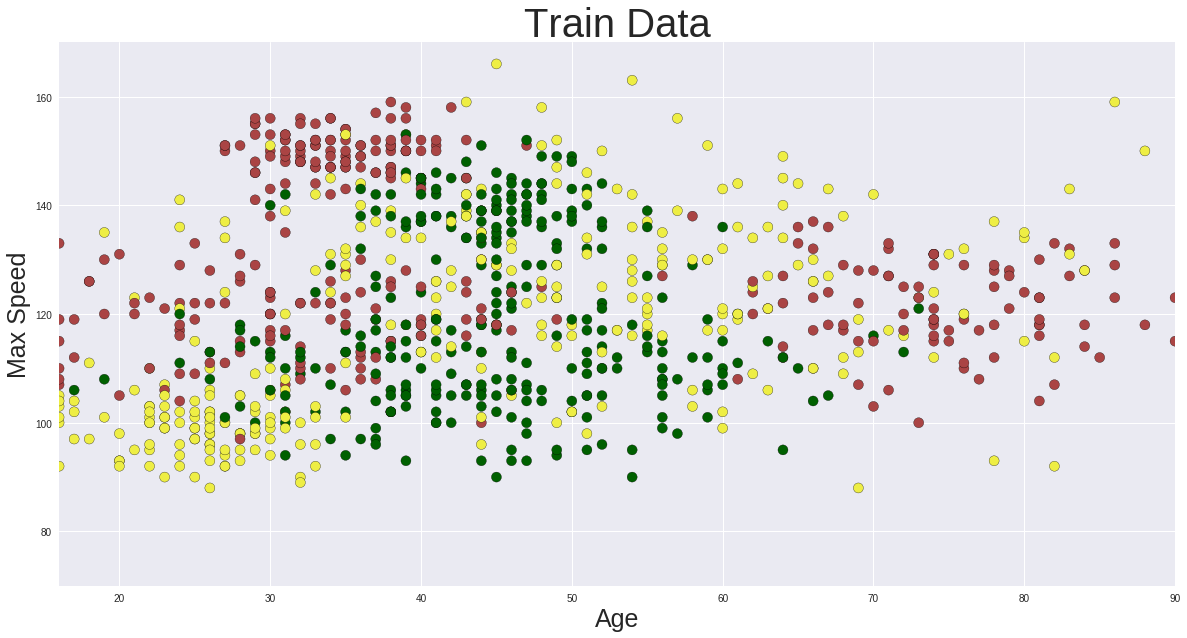

In [19]:
plot_prediction(None, X_train[:, 1], X_train[:, 0], 
               'Age', 'Max Speed', y_train, mesh=False,
                title="Train Data")

### A small exercise

* download the above plot of samples (https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/exercise/manual-decision-boundaries.pdf)
* work with your mouse or a digital pen in your favorite image editor
* draw decision boundaries to separate the different groups from each other
* try to minimize the number of falsely classified samples
* mark each section with what color you would precit for it
* use as few and as smooth lines as possible


### Same plot for test data
* note that we can see different areas
* how well would your decision boundaries work for that test data?
* be honest to yourself: were you overfitting?

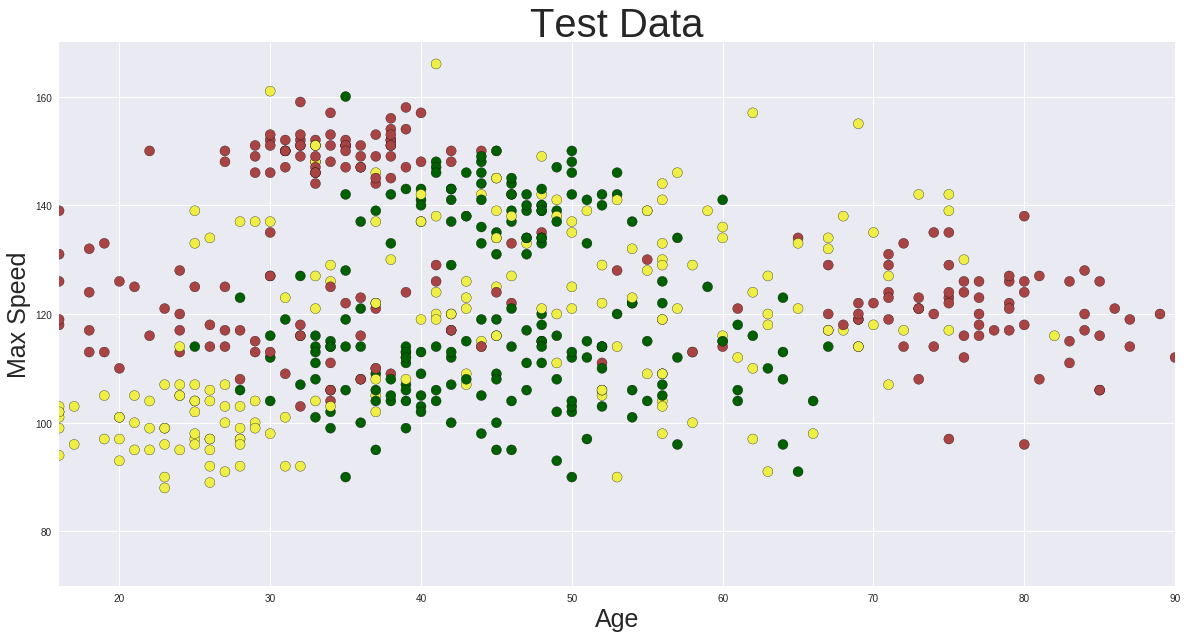

In [20]:
plot_prediction(None, X_test[:, 1], X_test[:, 0], 
               'Age', 'Max Speed', y_test, mesh=False,
                title="Test Data")

### For now, we restrict the input to the two dimensions seen before to be able to plot decision boudaries

In [0]:
X_train_2_dim = X_train[:, :2]
X_test_2_dim = X_test[:, :2]

num_categories = 3

### We use a sequential mode, that means data flows without junctions from in to out

In [0]:
model = keras.Sequential()

### We start with two layers each having 500 neurons, this should be more than enough capacity
* as a rule of thumb 2-3 hidden layers are a good initial choice

In [0]:
from tensorflow.keras.layers import Dense

model.add(Dense(500, name='hidden1', activation='tanh', input_dim=2))
model.add(Dense(500, name='hidden2', activation='tanh'))

### The final layer just transforms to likelyhood for each of our 3 classes

In [0]:
model.add(Dense(num_categories, name='softmax', activation='softmax'))

In [25]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
hidden1 (Dense)              (None, 500)               1500      
_________________________________________________________________
hidden2 (Dense)              (None, 500)               250500    
_________________________________________________________________
softmax (Dense)              (None, 3)                 1503      
Total params: 253,503
Trainable params: 253,503
Non-trainable params: 0
_________________________________________________________________


### This is how our decision boundaries look like _before_ training
* as they are random, they will look different when you re-create or re-run the model

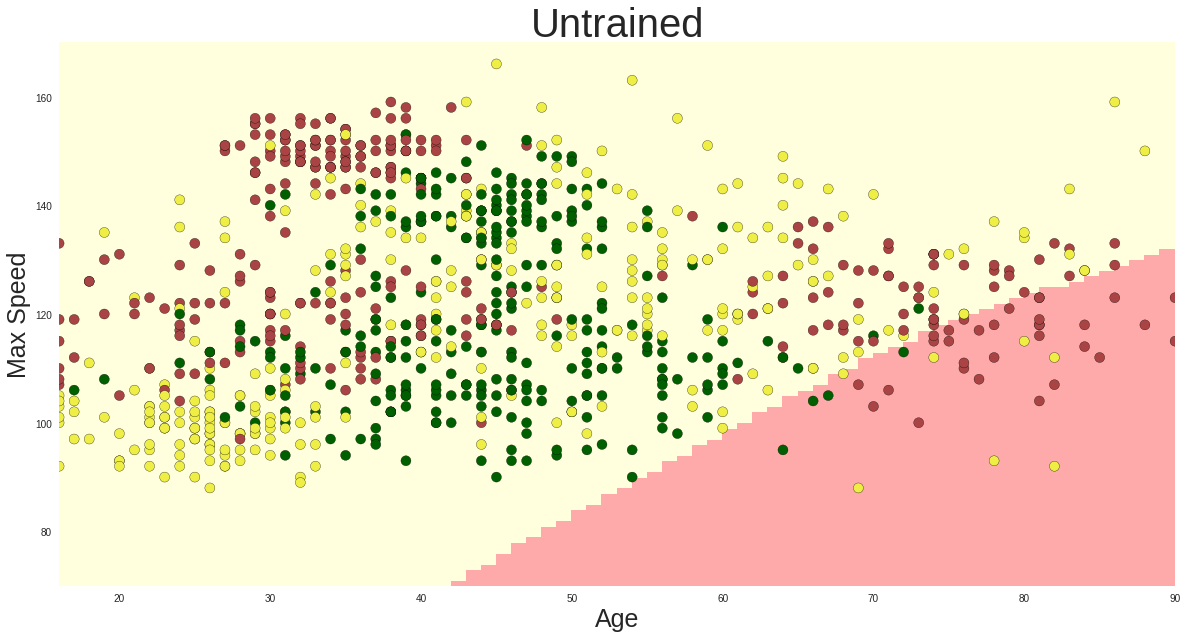

In [26]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Untrained")

In [0]:
model.compile(loss='sparse_categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [0]:
# only if you are running this locally

# https://keras.io/callbacks/#tensorboard
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./tf_log')
# To start tensorboard
# tensorboard --logdir=./tf_log
# open http://localhost:6006

## Validation Split

As test evaluation is a one-shot test, we again separate data for continues validation

<img src='https://raw.githubusercontent.com/DJCordhose/deep-learning-crash-course-notebooks/master/img/generalization2.jpg'>

In [29]:
BATCH_SIZE=1000
EPOCHS = 5000

# only if you are running this locally
# !rm -rf ./tf_log
# %time model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, callbacks=[tb_callback])

%time history = model.fit(X_train_2_dim, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=0.2, verbose=0)

CPU times: user 39.1 s, sys: 6.08 s, total: 45.2 s
Wall time: 34.4 s


In [30]:
train_loss, train_accuracy = model.evaluate(X_train_2_dim, y_train, batch_size=BATCH_SIZE)
train_accuracy

900/900 [==============================] - 0s 4us/step


0.7888888716697693

In [31]:
test_loss, test_accuracy = model.evaluate(X_test_2_dim, y_test, batch_size=BATCH_SIZE)
test_accuracy

600/600 [==============================] - 0s 7us/step


0.675000011920929

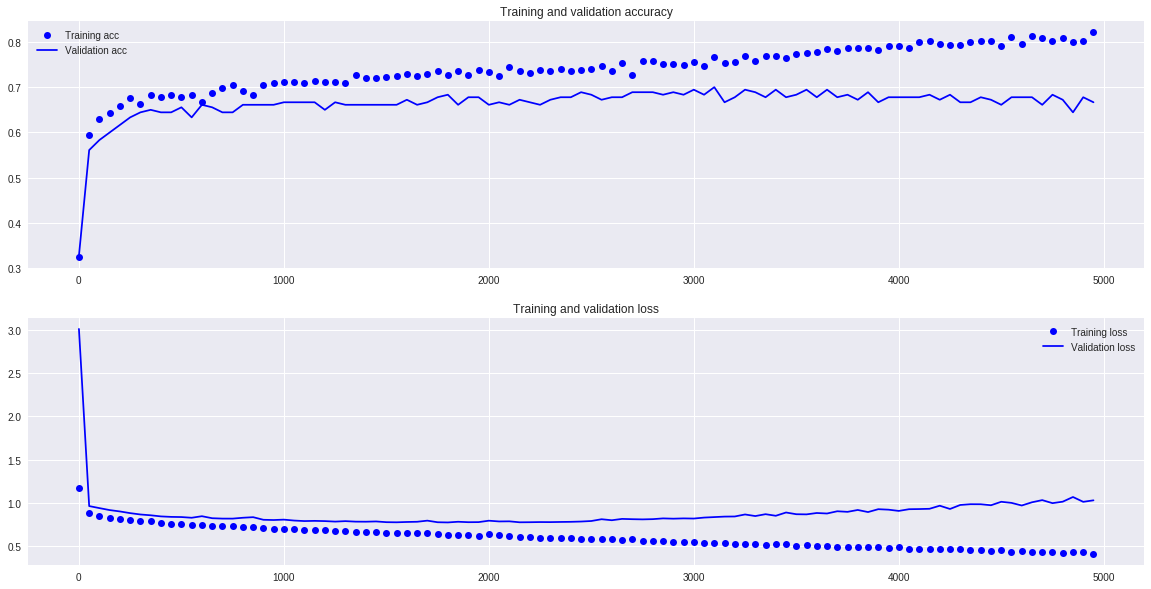

In [32]:
plot_history(history)

## There seems to be a large discrepancy between training and test loss
* up to 83% vs 66%
* number will vary as parameters are initialized randomly
* it seems if we trained for even longer it will still grow

## Objective: make the best prediction for unknown samples. 
* this is called generalization
* if we perform well on knwon data, but less good on unknown data this is called overfitting
* overfitting is to be avoided
* measures taken to avoid overfitting are also known as _regularization_.

### Let's plot the decision boundaries to get a better idea of what is going on
### First for training data

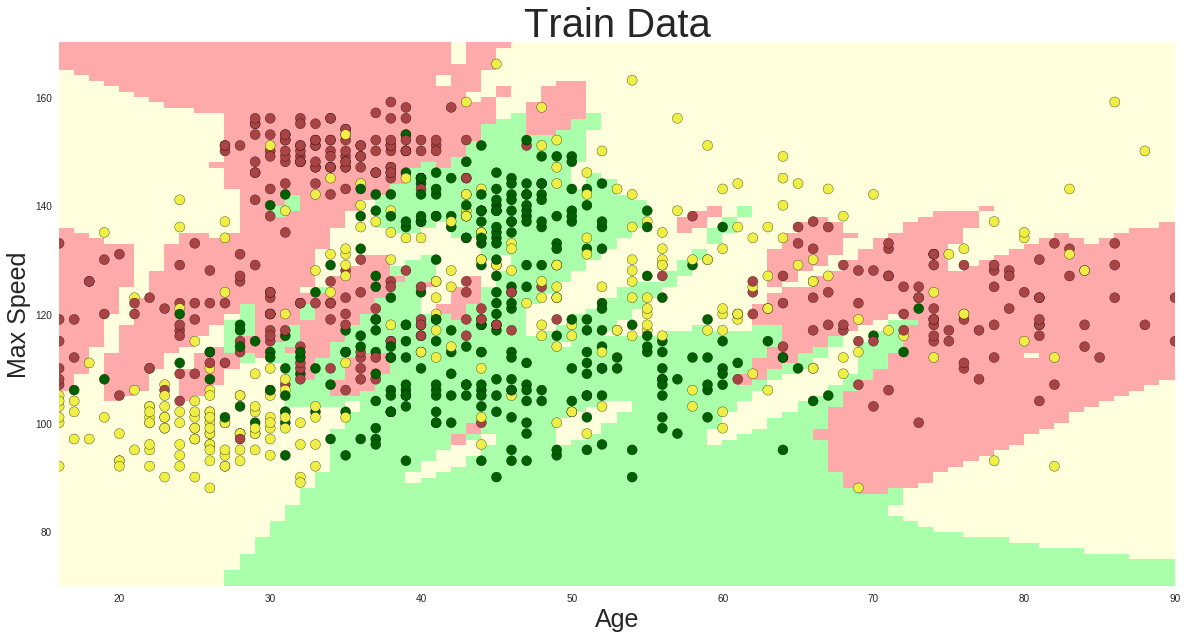

In [33]:
plot_prediction(model, X_train_2_dim[:, 1], X_train_2_dim[:, 0], 
               'Age', 'Max Speed', y_train,
                title="Train Data")

### Then for training data

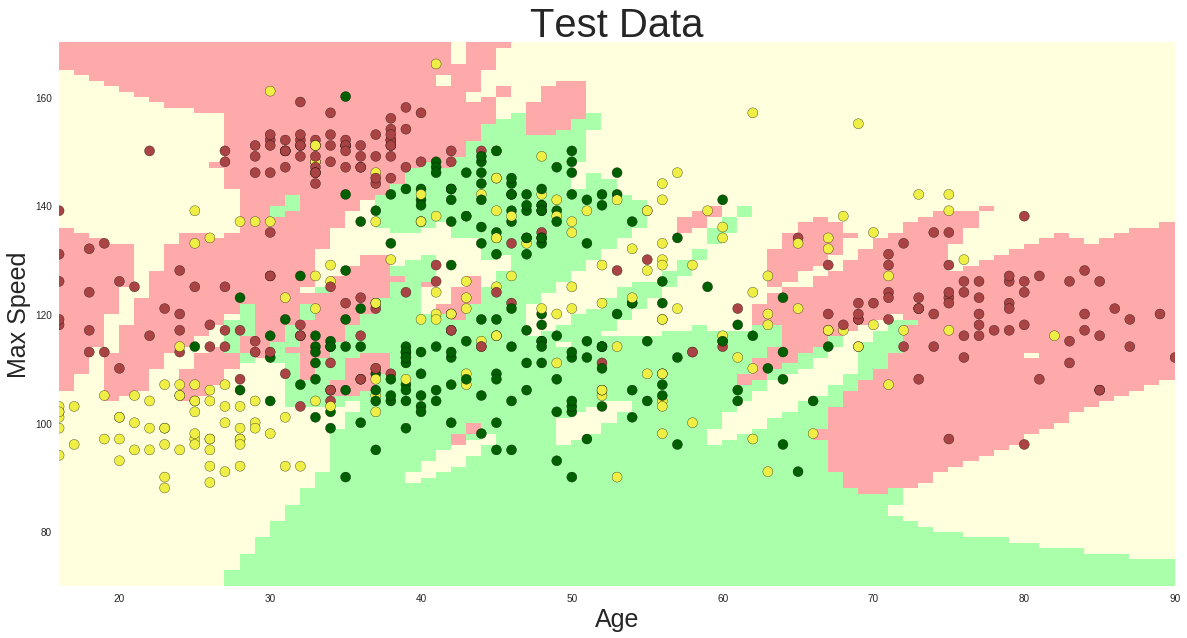

In [34]:
plot_prediction(model, X_test_2_dim[:, 1], X_test_2_dim[:, 0], 
               'Age', 'Max Speed', y_test,
                title="Test Data")

### A rule of thumb: Smoother decision boundaries imply less overfitting
This matches our observation: we detect overfitting and the decision boundaries also look rather wild, especially on the upper left side of the plot